### Full worklflow of employing CrystaLLM 2.0 for materials discovery

In [3]:
import __init__ # this just ensures were in the right env
from pymatgen.io.jarvis import JarvisAtomsAdaptor as JAA
from jarvis.core.atoms import Atoms
from pymatgen.io.cif import CifWriter
import json
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

### Step 1. Make the dataset in an apropriate format
- Data source
  - 1 json file that contains materials project material ids and their associated pmg structure objects
  - 1 json file that has the material ids and associated SLMEs
  > In the field of photovoltaics (PVs), SLME stands for Spectroscopic Limited Maximum Efficiency. It's a theoretical metric used to predict the maximum possible energy conversion efficiency of a solar cell material. Its more detailed and material-specific than the widely used Shockley-Queisser limit. See [this paper](https://arxiv.org/pdf/2507.13246) for more details on ML and SLMEs

- Columns we want to finetune CrystaLLM 2.0
  - We want to condition generation on SLME, to try and find novel materials with high SLMEs
  - 'Material ID': unique identifier, here for traceability of training data
  - 'Reduced Formula': This will be used to speed up novelty metric calculations
  - 'CIF': text sequences that the language model will train on
  - 'SLME': the property that the model will condition its sequence generation on

#### Lets build the dataset

In [2]:
def _symmetrize_cif(struct):
    """Convert structure to symmetrized CIF format with error handling."""
    sga = SpacegroupAnalyzer(struct)
    symm_struct = sga.get_symmetrized_structure()
    return str(CifWriter(symm_struct, symprec=0.1))
def structure_to_cif(struct):
    """Convert a pymatgen Structure to CIF format, attempting symmetrization first."""
    cif_str = _symmetrize_cif(struct)
    return cif_str
def extract_formula(struct):
    """Extract the reduced formula from a pymatgen Structure."""
    return struct.composition.reduced_formula

In [ ]:
with open('HF-databases/mpdb-slme/all_structures.json','r') as f:
    structure_dict = json.load(f)
with open('HF-databases/mpdb-slme/All_corr_SLMEs.json','r') as f:
    slme_dict = json.load(f)

df = pd.DataFrame(columns=['Material ID', 'Reduced Formula', 'CIF'])
for material_id, struct_dict in tqdm(structure_dict.items()):
    ats = Atoms.from_dict(struct_dict)
    structure = JAA.get_structure(ats)
    cif_str = structure_to_cif(structure)
    formula = extract_formula(structure)
    df = pd.concat([df, pd.DataFrame({'Material ID': [material_id], 'Reduced Formula': [formula], 'CIF': [cif_str]})], ignore_index=True)
    df['SLME'] = df['Material ID'].map(slme_dict)

df.to_parquet('HF-databases/mpdb-slme/mpdb-slme.parquet', index=False)

100%|██████████| 5346/5346 [01:09<00:00, 76.43it/s] 


#### We can visualise the distribution of SLMEs in the finetuning set 

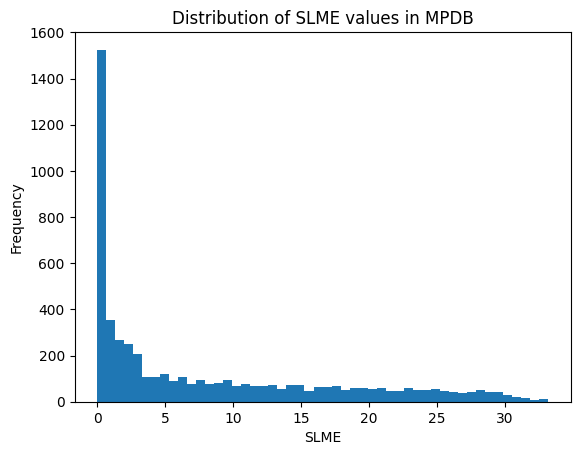

In [ ]:
plt.hist(df['SLME'].dropna(), bins=50)
plt.xlabel('SLME')
plt.ylabel('Frequency')
plt.title('Distribution of SLME values in MPDB')
plt.show()

#### Clean and augment the CIFs
- We turn the CIFs from standard into the correct format for CrystaLLM 2.0 training (process is invertible)
- We normalise the property we train on to stabilise training
- We also filtered so no augmented CIFs exceed context length (but none did so can skip)
> Note: We don't deduplicate because the dataset is already curated and each structure has different SLMEs so they are of interest for training. If you want to do this, see the [README.md](README.md)

In [ ]:
!python _utils/_preprocessing/_cleaning.py \
    --input_parquet HF-databases/mpdb-slme/mpdb-slme.parquet \
    --output_parquet HF-databases/mpdb-slme/mpdb-slme_clean_filtered.parquet \
    --property_columns "['SLME']" \
    --property1_normaliser "linear" \
    --num_workers 8 \
    --filter_to 1024

Loading data from HF-databases/mpdb-slme/mpdb-slme.parquet as Parquet with zstd compression...

Normalizing property columns

Normalizing with linear method for SLME...
Min value of SLME: 0.0
Min value of SLME after hardcoding: 0
Max value of SLME: 33.192
Max value of linear SLME: 1.0
Min value of linear SLME: 0.0

Lets augment the CIFs now (parallelizing sometimes takes a min before speeding up
Number of CIFs before preprocessing: 5346
Number of workers: 8
100%|█████████████████████████████████████| 5346/5346 [00:01<00:00, 4405.59it/s]
Number of CIFs before filtering out bad ones:  5346
Number of CIFs after filtering: 5346

Saving updated dataframe to HF-databases/mpdb-slme/mpdb-slme_clean.parquet as Parquet with zstd compression...
Preprocessing completed successfully.


### Save to HF
- Because we have a small dataset, we would like to train on all of it
- Datasets available on HuggingFace:
  - c-bone/mpdb-slme-full (100% - train)

In [4]:
!python _utils/_preprocessing/_save_dataset_to_HF.py \
    --input_parquet 'HF-databases/mpdb-slme/mpdb-slme_clean_filtered.parquet' \
    --output_parquet 'HF-databases/mpdb-slme/mpdb-slme-full.parquet' \
    --valid_size 0.00 \
    --test_size 0.00 \
    --save_hub

Loading Hugging Face API key from API_keys.jsonc
Loading data from HF-databases/mpdb-slme/mpdb-slme_clean_filtered.parquet as Parquet with zstd compression
Uploading the dataset shards: 100%|███████████████| 1/1 [00:01<00:00,  1.02s/it]
Dataset saved to Hugging Face Hub as c-bone/mpdb-slme-full


### Train the model
- I performed a quick hyperparameter search using a the same dataset but with a small validation set, best params stored in the config

In [ ]:
!torchrun --nproc_per_node=2 _train.py --config '_config_files/training/conditional/ft-slme/slme_ft-PKV-opt.jsonc'

#### Make Prompts
- Here the prompts are quite simple, we target any composition but the highest possible SLME

In [ ]:
!python _utils/_generating/make_prompts.py \
    --manual \
    --compositions "" \
    --condition_lists "1.0" \
    --output_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_prompt.parquet'


Generated manual prompts for 1 compositions and 1 condition lists

First 3 rows:
       Prompt condition_vector
<bos>\ndata_[              1.0

Saved 1 prompts to _utils/_evaluation_files/conditional_studies/slme/slme_prompt.parquet


#### Materials Generation
- With default params that balance exploration and exploitation of learned patterns

In [ ]:
!python _utils/_generating/generate_CIFs.py --config '_config_files/generation/conditional/slme/slme-PKV-opt_eval.jsonc'

Environment info
Available GPUs: 2
GPU 0: NVIDIA L4
GPU 1: NVIDIA L4

Generation settings
Total sequences per prompt-condition pair: 100
Will save generated CIFs to _utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_gent.parquet
Model's max_length: 1025
Tokenizer validation passed: token vocabulary is consistent.
Generation kwargs: {'max_length': 1024, 'pad_token_id': 371, 'eos_token_id': 373, 'renormalize_logits': True, 'remove_invalid_values': True, 'num_return_sequences': 5, 'do_sample': True, 'top_k': 50, 'top_p': 0.95, 'temperature': 1.0}

Generation
Number of condition-prompt pairs: 2
Tokenizer validation passed: token vocabulary is consistent.
Loading model with PKV conditionality...
Generating CIFs...:   0%|                               | 0/100 [00:00<?, ?it/s]Tokenizer validation passed: token vocabulary is consistent.
Loading model with PKV conditionality...
Tokenizer validation passed: token vocabulary is consistent.
Loading model with PKV conditionality...
Gene

#### Metrics
- We want to flag materials that are valid, unique, novel, and predicted stable for further analysis
- We can screen this pretty fast with the metrics scripts set up

In [ ]:
!python _utils/_metrics/VUN_metrics.py \
    --input_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_gen.parquet' \
    --huggingface_dataset 'c-bone/mpdb-slme-full' \
    --load_processed_data 'HF-databases/mpdb-slme/mpdb-slme-full_proc.parquet' \
    --output_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_post.parquet' \
    --num_workers 32

In [ ]:
!python _utils/_metrics/mace_ehull.py \
    --post_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_post.parquet' \
    --output_parquet '_utils/_evaluation_files/conditional_studies/slme/slme-PKV-opt_post-s.parquet' \
    --mp_data 'mp_computed_structure_entries.json.gz' \
    --num_workers 16

In [ ]:
import __init__
import pandas as pd
df = pd.read_parquet('_artifacts/slme/slme-PKV-opt_post-s.parquet')

valid_count = df['is_valid'].sum()
valid_unique_count = df[(df['is_valid']) & (df['is_unique'])].shape[0]
valid_unique_novel_count = df[(df['is_valid']) & (df['is_unique']) & (df['is_novel'])].shape[0]
low_ehull_count = df[(df['is_valid']) & (df['is_unique']) & (df['is_novel']) & (df['ehull_mace_mp'] < 0.1)].shape[0]
print(f"Valid entries: {valid_count}")
print(f"Valid and unique entries: {valid_unique_count}")
print(f"Valid, unique, and novel entries: {valid_unique_novel_count}")
print(f"Valid, unique, novel entries with ehull_mace_mp < 0.1: {low_ehull_count}")
print(f"Total entries: {len(df)}")

Valid entries: 83367
Valid and unique entries: 75252
Valid, unique, and novel entries: 73962
Valid, unique, novel entries with ehull_mace_mp < 0.1: 16463
Total entries: 100000
